In [1]:
# ============================================================================
# CONFIGURATION - Adjust these parameters as needed
# ============================================================================

class Config:
    # Dataset parameters
    IMG_SIZE = (224, 224)  # Image dimensions (height, width)
    TRAIN_VAL_SPLIT = 0.9  # Train/validation split ratio
    
    # DataLoader parameters
    BATCH_SIZE = 16  # Batch size for training
    NUM_WORKERS = 4  # Set to 0 for Windows, increase for Linux/Mac
    PIN_MEMORY = True  # Set to True if using GPU
    
    # Model architecture parameters
    # ResNet CBAM UNet uses pretrained ResNet50 as encoder
    IN_CHANNELS = 3  # RGB input channels
    OUT_CHANNELS = 1  # Binary segmentation output
    CBAM_REDUCTION = 4  # Reduction factor for CBAM attention modules
    
    # Training parameters
    NUM_EPOCHS = 30
    LEARNING_RATE =8e-5
    OPTIMIZER = 'adam'  # 'adam' or 'sgd'
    WEIGHT_DECAY = 0.0  # L2 regularization weight
    USE_CURRICULUM_LEARNING = False  # Enable/disable curriculum learning (sorts masks by area, progressive training)
    
    # Loss function parameters
    FOCAL_WEIGHT = 0.5  # Weight for Focal loss (segmentation)
    DICE_WEIGHT = 0.5  # Weight for Dice loss (segmentation)
    DICE_SMOOTH = 1e-6  # Smoothing factor for Dice loss (avoid division by zero)
    FOCAL_ALPHA = 0.25  # Alpha parameter for Focal loss (class balancing)
    FOCAL_GAMMA = 2.0  # Gamma parameter for Focal loss (focusing parameter)
    
    # Early stopping parameters
    PATIENCE = 99  # Number of epochs to wait before early stopping
    MIN_DELTA = 0.0  # Minimum change to qualify as improvement
    
    # Output directories
    OUTPUT_DIR = 'outputs'  # Main output directory
    VIZ_DIR = 'outputs/visualizations'  # Directory to save visualizations
    CHECKPOINT_DIR = 'outputs/checkpoints'  # Directory to save model checkpoints
    
    # Visualization parameters
    NUM_VIZ_IMAGES = 2  # Number of images to visualize per epoch
    
    # Model saving parameters
    MODEL_SAVE_NAME = 'unet_comofod_best.pth'  # Best model checkpoint name
    MODEL_COMPLETE_NAME = 'unet_comofod_complete.pth'  # Complete model save name
    
    # Dataset paths
    IMAGE_FOLDER = 'archive/copymove_img/img'
    DONOR_MASK_FOLDER = 'archive/copymove_annotations/donor_mask'
    PROBE_MASK_FOLDER = 'archive/copymove_annotations/probe_mask'
    
    # Augmentation parameters
    USE_AUGMENTATION = True  # Master switch: Enable/disable all data augmentation
    
    # Spatial augmentation switches (applied to both image and mask)
    AUG_ENABLE_ROTATION = True  # Enable/disable rotation augmentation
    AUG_ROTATION = 10  # Rotation angle in degrees (±) - only used if AUG_ENABLE_ROTATION=True
    AUG_ENABLE_HFLIP = True  # Enable/disable horizontal flip augmentation
    AUG_HFLIP = 0.5  # Probability of horizontal flip - only used if AUG_ENABLE_HFLIP=True
    AUG_ENABLE_VFLIP = True  # Enable/disable vertical flip augmentation
    AUG_VFLIP = 0.5  # Probability of vertical flip - only used if AUG_ENABLE_VFLIP=True
    
    # Color augmentation switches (applied to image only)
    AUG_ENABLE_COLOR = True  # Enable/disable color augmentations (brightness, contrast, saturation)
    AUG_BRIGHTNESS = 0.2  # Brightness adjustment range (±) - only used if AUG_ENABLE_COLOR=True
    AUG_CONTRAST = 0.2  # Contrast adjustment range (±) - only used if AUG_ENABLE_COLOR=True
    AUG_SATURATION = 0.2  # Saturation adjustment range (±) - only used if AUG_ENABLE_COLOR=True
    
    # Mask smoothing parameters
    MASK_GAUSSIAN_BLUR_RADIUS = 1.0  # Gaussian blur radius for mask label smoothing (0.0 = disabled)

# Create config instance
config = Config()

# Print configuration
print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
print(f"Image Size: {config.IMG_SIZE}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Model: MaxViT Base CBAM UNet (CBAM reduction={config.CBAM_REDUCTION})")
print(f"Epochs: {config.NUM_EPOCHS}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print(f"Optimizer: {config.OPTIMIZER}")
print(f"Segmentation Loss: Focal ({config.FOCAL_WEIGHT}, alpha={config.FOCAL_ALPHA}, gamma={config.FOCAL_GAMMA}) + Dice ({config.DICE_WEIGHT})")
print(f"Patience: {config.PATIENCE}")
print(f"Train/Val Split: {config.TRAIN_VAL_SPLIT}")
print(f"Curriculum Learning: {'ON' if config.USE_CURRICULUM_LEARNING else 'OFF'}")
print()
print("Augmentation Parameters:")
print(f"  Master Switch: {'ON' if config.USE_AUGMENTATION else 'OFF'}")
if config.USE_AUGMENTATION:
    print(f"  Spatial: Rotation={'ON' if config.AUG_ENABLE_ROTATION else 'OFF'} (±{config.AUG_ROTATION}°), "
          f"HFlip={'ON' if config.AUG_ENABLE_HFLIP else 'OFF'} (p={config.AUG_HFLIP}), "
          f"VFlip={'ON' if config.AUG_ENABLE_VFLIP else 'OFF'} (p={config.AUG_VFLIP})")
    print(f"  Color: {'ON' if config.AUG_ENABLE_COLOR else 'OFF'} "
          f"(Brightness=±{config.AUG_BRIGHTNESS}, Contrast=±{config.AUG_CONTRAST}, Saturation=±{config.AUG_SATURATION})")
else:
    print("  All augmentations disabled")
print("=" * 60)


TRAINING CONFIGURATION
Image Size: (224, 224)
Batch Size: 16
Model: MaxViT Base CBAM UNet (CBAM reduction=4)
Epochs: 30
Learning Rate: 8e-05
Optimizer: adam
Segmentation Loss: Focal (0.5, alpha=0.25, gamma=2.0) + Dice (0.5)
Patience: 99
Train/Val Split: 0.9
Curriculum Learning: OFF

Augmentation Parameters:
  Master Switch: ON
  Spatial: Rotation=ON (±10°), HFlip=ON (p=0.5), VFlip=ON (p=0.5)
  Color: ON (Brightness=±0.2, Contrast=±0.2, Saturation=±0.2)


In [2]:
# ============================================================================
# DOWNLOAD AND SAVE PRETRAINED WEIGHTS
# ============================================================================
# This cell downloads the MaxViT pretrained weights and saves them locally
# to avoid redownloading them each time you run the notebook.

import os
import torch
import timm

# Create pretrained_models directory if it doesn't exist
PRETRAINED_MODELS_DIR = 'pretrained_models'
os.makedirs(PRETRAINED_MODELS_DIR, exist_ok=True)

# Check if weights already exist
weight_files = ['model.safetensors', 'pytorch_model.bin', 'model.pth']
local_weights_path = None
weights_exist = False

for weight_file in weight_files:
    weight_path = os.path.join(PRETRAINED_MODELS_DIR, weight_file)
    if os.path.exists(weight_path):
        local_weights_path = weight_path
        weights_exist = True
        print(f"✓ Pretrained weights already exist at: {local_weights_path}")
        print("  Skipping download. Delete this file if you want to redownload.")
        break

# Download and save weights if they don't exist
if not weights_exist:
    print("=" * 60)
    print("DOWNLOADING PRETRAINED WEIGHTS")
    print("=" * 60)
    
    # Set environment variables for faster download
    os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'
    os.environ['HF_HUB_DOWNLOAD_TIMEOUT'] = '600'  # 10 minutes timeout
    
    try:
        print("Downloading MaxViT Base pretrained weights from Hugging Face...")
        # Download the model with pretrained weights (num_classes=0 removes classifier head)
        maxvit = timm.create_model(
            'maxvit_base_tf_224.in1k',
            pretrained=True,
            num_classes=0  # Remove classifier head
        )
        
        # Save the state dict to pretrained_models folder
        save_path = os.path.join(PRETRAINED_MODELS_DIR, 'model.pth')
        torch.save(maxvit.state_dict(), save_path)
        
        print(f"✓ Successfully downloaded and saved pretrained weights!")
        print(f"  Saved to: {save_path}")
        print(f"  File size: {os.path.getsize(save_path) / (1024**2):.2f} MB")
        
    except Exception as e:
        print(f"⚠ Warning: Failed to download with primary model name: {e}")
        print("Trying alternative model name...")
        try:
            maxvit = timm.create_model(
                'maxvit_base_tf_224',
                pretrained=True,
                num_classes=0
            )
            
            # Save the state dict
            save_path = os.path.join(PRETRAINED_MODELS_DIR, 'model.pth')
            torch.save(maxvit.state_dict(), save_path)
            
            print(f"✓ Successfully downloaded and saved pretrained weights!")
            print(f"  Saved to: {save_path}")
            print(f"  File size: {os.path.getsize(save_path) / (1024**2):.2f} MB")
            
        except Exception as e2:
            print(f"✗ Error: Failed to download pretrained weights: {e2}")
            print("  The model will be created without pretrained weights.")
            print("  You can train from scratch or manually download the weights.")

print("=" * 60)


✓ Pretrained weights already exist at: pretrained_models/model.pth
  Skipping download. Delete this file if you want to redownload.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class ChannelAttention(nn.Module):
    """Channel Attention Module (SE-Net style)"""
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Use full channels without reduction
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x shape: (B, C, H, W)
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    """Spatial Attention Module"""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x shape: (B, C, H, W)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

class CBAM(nn.Module):
    """Convolutional Block Attention Module (Channel + Spatial)"""
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        # Apply channel attention first
        x = x * self.channel_attention(x)
        # Then apply spatial attention
        x = x * self.spatial_attention(x)
        return x

class Coder(nn.Module):
    """Decoder block for UNet - processes concatenated features"""
    def __init__(self, in_channels, out_channels):
        super(Coder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.conv2(x)
        x = self.bn2(x)
        return F.relu(x, inplace=True)

class MaxViT_CBAM_UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, r=16):
        super(MaxViT_CBAM_UNet, self).__init__()
        
        # Load pretrained MaxViT Base from timm (224x224 pretrained)
        # Note: Correct model name is 'maxvit_base_tf_224' (tf = TensorFlow weights)
        
        # Load MaxViT Base model (embeddings only, no classifier head)
        # Using num_classes=0 removes the classifier nn.Linear layer
        
        import os
        PRETRAINED_MODELS_DIR = 'pretrained_models'
        os.makedirs(PRETRAINED_MODELS_DIR, exist_ok=True)
        weights_loaded = False
        
        # Check for downloaded weights in local folder
        weight_files = ['model.safetensors', 'pytorch_model.bin', 'model.pth']
        local_weights_path = None
        
        for weight_file in weight_files:
            weight_path = os.path.join(PRETRAINED_MODELS_DIR, weight_file)
            if os.path.exists(weight_path):
                local_weights_path = weight_path
                break
        
        # Try loading from local folder first
        if local_weights_path:
            try:
                print(f"Loading MaxViT from local weights: {local_weights_path}")
                # Create model without classifier head (num_classes=0)
                maxvit = timm.create_model(
                    'maxvit_base_tf_224.in1k',
                    pretrained=False,
                    num_classes=0  # Remove classifier head
                )
                
                # Load the weights
                if local_weights_path.endswith('.safetensors'):
                    from safetensors.torch import load_file
                    state_dict = load_file(local_weights_path)
                else:
                    state_dict = torch.load(local_weights_path, map_location='cpu')
                
                # Filter state dict to match model architecture (remove classifier head keys)
                model_dict = maxvit.state_dict()
                filtered_dict = {}
                for k, v in state_dict.items():
                    # Skip classifier head keys (head.* or classifier.*)
                    if 'head.' in k or 'classifier.' in k:
                        continue
                    if k in model_dict and v.shape == model_dict[k].shape:
                        filtered_dict[k] = v
                
                missing_keys, unexpected_keys = maxvit.load_state_dict(filtered_dict, strict=False)
                if missing_keys:
                    print(f"  Note: {len(missing_keys)} keys not loaded")
                if unexpected_keys:
                    print(f"  Note: {len(unexpected_keys)} unexpected keys ignored (including classifier head)")
                
                weights_loaded = True
                print("✓ Successfully loaded pretrained weights from local folder!")
                print("  Skipping download - using cached weights.")
                
            except Exception as e:
                print(f"⚠ Failed to load from local folder: {e}")
                print("Falling back to automatic download...")
                weights_loaded = False
        
        # If local loading failed, try automatic download (and save for future use)
        if not weights_loaded:
            os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'
            os.environ['HF_HUB_DOWNLOAD_TIMEOUT'] = '600'  # 10 minutes timeout
            
            try:
                print("Downloading MaxViT pretrained weights from Hugging Face...")
                # Use num_classes=0 to get embeddings only (no classifier head)
                maxvit = timm.create_model(
                    'maxvit_base_tf_224.in1k',
                    pretrained=True,
                    num_classes=0  # Remove classifier nn.Linear
                )
                weights_loaded = True
                print("✓ Successfully downloaded and loaded pretrained weights!")
                
                # Save the weights to pretrained_models folder for future use
                save_path = os.path.join(PRETRAINED_MODELS_DIR, 'model.pth')
                torch.save(maxvit.state_dict(), save_path)
                print(f"✓ Saved weights to {save_path} for future use")
                print(f"  File size: {os.path.getsize(save_path) / (1024**2):.2f} MB")
                
            except Exception as e:
                print(f"⚠ Warning: Failed to load pretrained weights: {e}")
                print("Trying alternative model name...")
                try:
                    maxvit = timm.create_model(
                        'maxvit_base_tf_224',
                        pretrained=True,
                        num_classes=0
                    )
                    weights_loaded = True
                    print("✓ Successfully loaded with alternative model name!")
                    
                    # Save the weights to pretrained_models folder for future use
                    save_path = os.path.join(PRETRAINED_MODELS_DIR, 'model.pth')
                    torch.save(maxvit.state_dict(), save_path)
                    print(f"✓ Saved weights to {save_path} for future use")
                    print(f"  File size: {os.path.getsize(save_path) / (1024**2):.2f} MB")
                    
                except Exception as e2:
                    print(f"⚠ Warning: Failed to load pretrained weights: {e2}")
                    print("Creating model without pretrained weights. You can train from scratch.")
                    print("  Tip: Run the 'Download and Save Pretrained Weights' cell first to download weights.")
                    maxvit = timm.create_model('maxvit_base_tf_224', pretrained=False, num_classes=0)
                    weights_loaded = False
        
        # MaxViT Base feature dimensions (for 224x224 input):
        # Stem: 64 channels, H/2 x W/2 (112x112)
        # Stage 1: 96 channels, H/4 x W/4 (56x56)
        # Stage 2: 192 channels, H/8 x W/8 (28x28)
        # Stage 3: 384 channels, H/16 x W/16 (14x14)
        # Stage 4: 768 channels, H/32 x W/32 (7x7)
        
        # Extract encoder stages from MaxViT
        # Access the internal structure of MaxViT
        self.encoder1 = nn.Identity()  # Input: (B, 3, H, W)
        
        # Get the stem and stages from MaxViT
        # MaxViT structure: stem -> stages[0] -> stages[1] -> stages[2] -> stages[3]
        self.stem = maxvit.stem  # Stem: (B, 3, H, W) -> (B, 64, H/2, W/2)
        self.stage1 = maxvit.stages[0]  # Stage 1: (B, 64, H/2, W/2) -> (B, 96, H/4, W/4)
        self.stage2 = maxvit.stages[1]  # Stage 2: (B, 96, H/4, W/4) -> (B, 192, H/8, W/8)
        self.stage3 = maxvit.stages[2]  # Stage 3: (B, 192, H/8, W/8) -> (B, 384, H/16, W/16)
        self.stage4 = maxvit.stages[3]  # Stage 4: (B, 384, H/16, W/16) -> (B, 768, H/32, W/32)
        
        # Encoder blocks
        # We'll use stem output separately for skip connection
        self.encoder2 = nn.Sequential(self.stem, self.stage1)  # Out: (B, 96, H/4, W/4)
        self.se2 = CBAM(96 * 2, r)  # Skip connection: decoder + encoder2
        
        self.encoder3 = self.stage2  # Out: (B, 192, H/8, W/8)
        self.se3 = CBAM(192 * 2, r)
        
        self.encoder4 = self.stage3  # Out: (B, 384, H/16, W/16)
        self.se4 = CBAM(384 * 2, r)
        
        self.encoder5 = self.stage4  # Out: (B, 768, H/32, W/32)
        # Note: se5 not needed since we skip from e4, not e5
        
        # Bottleneck (no additional layer needed, stage4 is the bottleneck)
        self.bottleneck = nn.Identity()  # (B, 768, H/32, W/32)

        # Decoder path - channels must match encoder outputs
        self.upconv5 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)  # (B, 384, H/16, W/16)
        self.decoder5 = Coder(384 * 2, 384)  # Skip: 384 (decoder) + 384 (encoder4)
        
        self.upconv4 = nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2)  # (B, 192, H/8, W/8)
        self.decoder4 = Coder(192 * 2, 192)  # Skip: 192 (decoder) + 192 (encoder3)
        
        self.upconv3 = nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2)  # (B, 96, H/4, W/4)
        self.decoder3 = Coder(96 * 2, 96)  # Skip: 96 (decoder) + 96 (encoder2)
        
        # For the final upsampling, we need to go from H/4 to H/2, then H/2 to H
        # Stage 1 output is at H/4, so we need one more upsampling step
        self.upconv2 = nn.ConvTranspose2d(96, 64, kernel_size=2, stride=2)  # (B, 64, H/2, W/2)
        # We'll use stem output (64 channels at H/2) for skip connection
        self.se2_stem = CBAM(64 * 2, r)  # Skip: 64 (decoder) + 64 (stem)
        self.decoder2 = Coder(64 * 2, 64)
        
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # (B, 64, H, W)
        self.se1 = CBAM(64 + 3, r)  # Skip: 64 (decoder) + 3 (input)
        self.decoder1 = Coder(64 + 3, 64)
        
        self.conv = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)
        
        self.training_losses = []
        self.eval_losses = []
        self.training_iou = []
        self.eval_iou = []
    
    def forward(self, x):
        # Encoder path
        e1 = self.encoder1(x)  # (B, 3, H, W) - original input
        
        # Get stem output for skip connection
        stem_out = self.stem(e1)  # (B, 64, H/2, W/2)
        
        # Encoder stages
        e2 = self.encoder2(e1)  # (B, 96, H/4, W/4) - stem + stage1
        e3 = self.encoder3(e2)  # (B, 192, H/8, W/8) - stage2
        e4 = self.encoder4(e3)  # (B, 384, H/16, W/16) - stage3
        e5 = self.encoder5(e4)  # (B, 768, H/32, W/32) - stage4
        
        # Bottleneck
        bottleneck = self.bottleneck(e5)  # (B, 768, H/32, W/32)
        
        # Decoder path with skip connections and CBAM
        d5 = self.upconv5(bottleneck)  # (B, 384, H/16, W/16)
        d5 = torch.cat([d5, e4], dim=1)  # (B, 384*2, H/16, W/16)
        d5 = self.se4(d5)  # Apply CBAM
        d5 = self.decoder5(d5)  # (B, 384, H/16, W/16)
        
        d4 = self.upconv4(d5)  # (B, 192, H/8, W/8)
        d4 = torch.cat([d4, e3], dim=1)  # (B, 192*2, H/8, W/8)
        d4 = self.se3(d4)  # Apply CBAM
        d4 = self.decoder4(d4)  # (B, 192, H/8, W/8)
        
        d3 = self.upconv3(d4)  # (B, 96, H/4, W/4)
        d3 = torch.cat([d3, e2], dim=1)  # (B, 96*2, H/4, W/4)
        d3 = self.se2(d3)  # Apply CBAM
        d3 = self.decoder3(d3)  # (B, 96, H/4, W/4)
        
        d2 = self.upconv2(d3)  # (B, 64, H/2, W/2)
        d2 = torch.cat([d2, stem_out], dim=1)  # (B, 64*2, H/2, W/2)
        d2 = self.se2_stem(d2)  # Apply CBAM
        d2 = self.decoder2(d2)  # (B, 64, H/2, W/2)
        
        d1 = self.upconv1(d2)  # (B, 64, H, W)
        d1 = torch.cat([d1, e1], dim=1)  # (B, 64+3, H, W)
        d1 = self.se1(d1)  # Apply CBAM
        d1 = self.decoder1(d1)  # (B, 64, H, W)
        
        # Output layer
        output = self.conv(d1)  # (B, 1, H, W) - logits
        
        return output

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MaxViT_CBAM_UNet(
    in_channels=config.IN_CHANNELS, 
    out_channels=config.OUT_CHANNELS,
    r=config.CBAM_REDUCTION
).to(device)
print(f"Model created on device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(model)

Loading MaxViT from local weights: pretrained_models/model.pth
  Note: 4 keys not loaded
✓ Successfully loaded pretrained weights from local folder!
  Skipping download - using cached weights.
Model created on device: cuda
Total parameters: 126,701,937
MaxViT_CBAM_UNet(
  (encoder1): Identity()
  (stem): Stem(
    (conv1): Conv2dSame(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (norm1): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): GELUTanh()
    )
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (stage1): MaxxVitStage(
    (blocks): Sequential(
      (0): MaxxVitBlock(
        (conv): MbConvBlock(
          (shortcut): Downsample2d(
            (pool): AvgPool2dSame(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
            (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
          )
          (pre_norm): BatchNormAct2d(
            64, eps=0.001, moment

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
import os

class JointTransform:
    """Apply the same spatial transformations to both image and mask"""
    def __init__(self, rotation=15, hflip_prob=0.5, vflip_prob=0.0, 
                 enable_rotation=True, enable_hflip=True, enable_vflip=True):
        self.rotation = rotation if enable_rotation else 0
        self.hflip_prob = hflip_prob if enable_hflip else 0.0
        self.vflip_prob = vflip_prob if enable_vflip else 0.0
    
    def __call__(self, img, mask):
        # Random rotation
        if self.rotation > 0:
            angle = random.uniform(-self.rotation, self.rotation)
            img = TF.rotate(img, angle, interpolation=TF.InterpolationMode.BILINEAR, fill=0)
            mask = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST, fill=0)
        
        # Random horizontal flip
        if self.hflip_prob > 0 and random.random() < self.hflip_prob:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        
        # Random vertical flip
        if self.vflip_prob > 0 and random.random() < self.vflip_prob:
            img = TF.vflip(img)
            mask = TF.vflip(mask)
        
        return img, mask

class ImageMaskDataset(Dataset):
    def __init__(self, image_folder, donor_mask_folder, probe_mask_folder, img_size=(512, 512), transform=None, joint_transform=None, mask_blur_radius=0.0):
        """
        Dataset for copymove forgery detection.
        
        Args:
            image_folder: Path to folder containing images (.tif files)
            donor_mask_folder: Path to folder containing donor masks (.tif files)
            probe_mask_folder: Path to folder containing probe masks (.jpg files)
            img_size: Target size for resizing images and masks (height, width)
            transform: Image-only transforms (brightness, contrast, etc.)
            joint_transform: Spatial transforms applied to both image and mask
            mask_blur_radius: Gaussian blur radius for mask label smoothing (0.0 = disabled)
        """
        # Get all image files and sort them
        self.image_paths = sorted([
            os.path.join(image_folder, f) 
            for f in os.listdir(image_folder) 
            if f.endswith('.tif')
        ])
        
        # Build corresponding mask paths
        self.donor_mask_paths = []
        self.probe_mask_paths = []
        
        for img_path in self.image_paths:
            filename = os.path.basename(img_path)
            # Donor mask has same filename with .tif extension
            donor_mask_path = os.path.join(donor_mask_folder, filename)
            # Probe mask has same base name but .jpg extension
            probe_mask_filename = os.path.splitext(filename)[0] + '.jpg'
            probe_mask_path = os.path.join(probe_mask_folder, probe_mask_filename)
            
            self.donor_mask_paths.append(donor_mask_path)
            self.probe_mask_paths.append(probe_mask_path)
        
        self.img_size = img_size
        self.transform = transform  # For image-only transforms (brightness, contrast, etc.)
        self.joint_transform = joint_transform  # For spatial transforms (rotation, flip)
        self.mask_blur_radius = mask_blur_radius  # Gaussian blur radius for mask smoothing
    
    def _apply_mask_blur(self, mask):
        """Apply Gaussian blur to mask if blur radius > 0"""
        if self.mask_blur_radius > 0:
            # Use cv2.GaussianBlur for efficient blurring
            # kernel_size must be odd, calculate from sigma
            # sigma = blur_radius, kernel_size = 2 * ceil(3*sigma) + 1
            import math
            kernel_size = int(2 * math.ceil(3 * self.mask_blur_radius) + 1)
            # Ensure kernel_size is odd
            if kernel_size % 2 == 0:
                kernel_size += 1
            mask = cv2.GaussianBlur(mask, (kernel_size, kernel_size), self.mask_blur_radius)
        return mask
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_UNCHANGED)
        if img is None:
            raise ValueError(f"Failed to load image: {self.image_paths[idx]}")
        
        # Handle different image formats (RGB, grayscale, etc.)
        if len(img.shape) == 2:
            # Grayscale image, convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            # RGBA image, convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        else:
            # BGR image, convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image to target size
        # Use INTER_AREA for better quality when downsampling (reduces blur)
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        
        # Load donor mask
        donor_mask = cv2.imread(self.donor_mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        if donor_mask is None:
            # If donor mask doesn't exist, create empty mask
            donor_mask = np.zeros(self.img_size, dtype=np.uint8)
        else:
            # Resize donor mask to target size
            donor_mask = cv2.resize(donor_mask, self.img_size, interpolation=cv2.INTER_NEAREST)
        
        # Load probe mask
        probe_mask = cv2.imread(self.probe_mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        if probe_mask is None:
            # If probe mask doesn't exist, create empty mask
            probe_mask = np.zeros(self.img_size, dtype=np.uint8)
        else:
            # Resize probe mask to target size
            probe_mask = cv2.resize(probe_mask, self.img_size, interpolation=cv2.INTER_NEAREST)
        
        # Combine donor and probe masks into a single mask
        # Use maximum to combine both masks (union operation)
        combined_mask = np.maximum(donor_mask, probe_mask)
        
        # Apply Gaussian blur for label smoothing if enabled
        combined_mask = self._apply_mask_blur(combined_mask)
        
        # Normalize mask to [0, 1] range
        combined_mask = combined_mask.astype(np.float32) / 255.0
        
        # Convert to PyTorch tensors: (H, W, C) -> (C, H, W)
        img = torch.from_numpy(img).permute(2, 0, 1)  # (3, H, W)
        mask = torch.from_numpy(combined_mask).unsqueeze(0)  # (1, H, W)
        
        # Apply joint spatial transformations (rotation, flip) to both image and mask
        if self.joint_transform:
            img, mask = self.joint_transform(img, mask)
        
        # Apply image-only transformations (brightness, contrast, saturation)
        if self.transform:
            img = self.transform(img)
        
        # Apply ImageNet normalization for MaxViT (pretrained on ImageNet)
        # This should be applied AFTER all augmentations
        # Mean and std for ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = (img - mean) / std
        
        # Classification label: All images in this dataset are forged
        class_label = torch.tensor(1.0, dtype=torch.float32)
        
        return img, mask, class_label

# Create augmentation transforms
if config.USE_AUGMENTATION:
    # Joint spatial transforms (applied to both image and mask)
    # Only apply if individual switches are enabled
    train_joint_transform = JointTransform(
        rotation=config.AUG_ROTATION if config.AUG_ENABLE_ROTATION else 0,
        hflip_prob=config.AUG_HFLIP if config.AUG_ENABLE_HFLIP else 0.0,
        vflip_prob=config.AUG_VFLIP if config.AUG_ENABLE_VFLIP else 0.0,
        enable_rotation=config.AUG_ENABLE_ROTATION,
        enable_hflip=config.AUG_ENABLE_HFLIP,
        enable_vflip=config.AUG_ENABLE_VFLIP
    )
    
    # Image-only color transforms (only applied to image)
    # Only apply if color augmentation is enabled
    if config.AUG_ENABLE_COLOR:
        train_image_transform = transforms.Compose([
            transforms.ColorJitter(
                brightness=config.AUG_BRIGHTNESS,
                contrast=config.AUG_CONTRAST,
                saturation=config.AUG_SATURATION,
                hue=0.0  # Keep hue unchanged for forgery detection
            )
        ])
    else:
        train_image_transform = None
    
    # Validation: no augmentations
    val_joint_transform = None
    val_image_transform = None
else:
    # Master switch disabled - no augmentations
    train_joint_transform = None
    train_image_transform = None
    val_joint_transform = None
    val_image_transform = None

# Print augmentation status
print(f"\nAugmentation Configuration:")
print(f"  Master Switch: {'ON' if config.USE_AUGMENTATION else 'OFF'}")
if config.USE_AUGMENTATION:
    print(f"  Spatial Augmentations:")
    print(f"    Rotation: {'ON' if config.AUG_ENABLE_ROTATION else 'OFF'} (angle: ±{config.AUG_ROTATION}°)")
    print(f"    Horizontal Flip: {'ON' if config.AUG_ENABLE_HFLIP else 'OFF'} (prob: {config.AUG_HFLIP})")
    print(f"    Vertical Flip: {'ON' if config.AUG_ENABLE_VFLIP else 'OFF'} (prob: {config.AUG_VFLIP})")
    print(f"  Color Augmentations: {'ON' if config.AUG_ENABLE_COLOR else 'OFF'}")
    if config.AUG_ENABLE_COLOR:
        print(f"    Brightness: ±{config.AUG_BRIGHTNESS}")
        print(f"    Contrast: ±{config.AUG_CONTRAST}")
        print(f"    Saturation: ±{config.AUG_SATURATION}")

# Initialize datasets
# Training dataset with augmentations
train_dataset = ImageMaskDataset(
    image_folder=config.IMAGE_FOLDER,
    donor_mask_folder=config.DONOR_MASK_FOLDER,
    probe_mask_folder=config.PROBE_MASK_FOLDER,
    img_size=config.IMG_SIZE,
    transform=train_image_transform,
    joint_transform=train_joint_transform,
    mask_blur_radius=config.MASK_GAUSSIAN_BLUR_RADIUS
)

# Validation dataset without augmentations
val_dataset = ImageMaskDataset(
    image_folder=config.IMAGE_FOLDER,
    donor_mask_folder=config.DONOR_MASK_FOLDER,
    probe_mask_folder=config.PROBE_MASK_FOLDER,
    img_size=config.IMG_SIZE,
    transform=val_image_transform,
    joint_transform=val_joint_transform,
    mask_blur_radius=config.MASK_GAUSSIAN_BLUR_RADIUS
)

# Use train_dataset for indexing (both datasets have same structure)
full_dataset = train_dataset

print(f"Total images: {len(full_dataset)}")
print("Note: All images in this dataset are forged (copymove forgeries)")

# Test one sample
sample_img, sample_mask, sample_class = full_dataset[0]
print(f"\nSample shape - Image: {sample_img.shape}, Mask: {sample_mask.shape}, Class: {sample_class}")
print(f"Image dtype: {sample_img.dtype}, Mask dtype: {sample_mask.dtype}, Class dtype: {sample_class.dtype}")


Augmentation Configuration:
  Master Switch: ON
  Spatial Augmentations:
    Rotation: ON (angle: ±10°)
    Horizontal Flip: ON (prob: 0.5)
    Vertical Flip: ON (prob: 0.5)
  Color Augmentations: ON
    Brightness: ±0.2
    Contrast: ±0.2
    Saturation: ±0.2
Total images: 10523
Note: All images in this dataset are forged (copymove forgeries)

Sample shape - Image: torch.Size([3, 224, 224]), Mask: torch.Size([1, 224, 224]), Class: 1.0
Image dtype: torch.float32, Mask dtype: torch.float32, Class dtype: torch.float32


In [5]:
# ============================================================================
# DATASET SPLIT AND SETUP
# ============================================================================

from torch.utils.data import DataLoader, random_split

print("=" * 60)
print("DATASET SPLIT AND SETUP")
print("=" * 60)

# Create train/val split using random_split directly on datasets
total_size = len(train_dataset)
train_size = int(config.TRAIN_VAL_SPLIT * total_size)
val_size = total_size - train_size

# Split datasets directly (random_split returns Subset objects)
train_dataset_split, val_dataset_split = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"\nDataset Split:")
print(f"  Total: {total_size} images (all forged)")
print(f"  Train: {len(train_dataset_split)} images")
print(f"  Val: {len(val_dataset_split)} images")

# Create dataloaders (will be updated by curriculum learning if enabled)
train_loader = DataLoader(
    train_dataset_split,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY
)

val_loader = DataLoader(
    val_dataset_split,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY
)

print(f"\nDataLoaders created:")
print(f"  Train loader: {len(train_loader)} batches")
print(f"  Validation loader: {len(val_loader)} batches")

# Initialize training history
history = {
    'train_loss': [],
    'train_iou': [],
    'val_loss': [],
    'val_iou': []
}

# Initialize early stopping parameters
best_val_loss = float('inf')
patience = config.PATIENCE
patience_counter = 0
best_model_state = None

print("\n" + "=" * 60)
print("Setup complete! Ready for training.")
print("=" * 60)



DATASET SPLIT AND SETUP

Dataset Split:
  Total: 10523 images (all forged)
  Train: 9470 images
  Val: 1053 images

DataLoaders created:
  Train loader: 592 batches
  Validation loader: 66 batches

Setup complete! Ready for training.


In [6]:
# ============================================================================
# CURRICULUM LEARNING: Sort masks by area and create progressive samplers
# ============================================================================

from torch.utils.data import Subset, WeightedRandomSampler
import torch
from tqdm import tqdm

# Only run curriculum learning setup if enabled in config
if config.USE_CURRICULUM_LEARNING:
    print("=" * 60)
    print("CURRICULUM LEARNING SETUP")
    print("=" * 60)

    # Step 1: Calculate mask areas for all training samples
    print("\nStep 1: Calculating mask areas for all training samples...")
    train_mask_areas = []
    train_indices = []

    # Get all indices from train_dataset_split (it's a Subset)
    for subset_idx in tqdm(range(len(train_dataset_split)), desc="Computing train mask areas"):
        _, mask, _ = train_dataset_split[subset_idx]
        # Calculate mask area (number of non-zero pixels)
        area = mask.sum().item()  # Sum of all mask pixels
        train_mask_areas.append(area)
        train_indices.append(subset_idx)

    train_mask_areas = np.array(train_mask_areas)
    train_indices = np.array(train_indices)

    print(f"  Total training samples: {len(train_mask_areas)}")
    print(f"  Mask area range: {train_mask_areas.min():.0f} - {train_mask_areas.max():.0f} pixels")
    print(f"  Mean mask area: {train_mask_areas.mean():.1f} pixels")
    print(f"  Median mask area: {np.median(train_mask_areas):.1f} pixels")

    # Step 1b: Calculate mask areas for all validation samples
    print("\nStep 1b: Calculating mask areas for all validation samples...")
    val_mask_areas = []
    val_indices = []

    for subset_idx in tqdm(range(len(val_dataset_split)), desc="Computing val mask areas"):
        _, mask, _ = val_dataset_split[subset_idx]
        area = mask.sum().item()
        val_mask_areas.append(area)
        val_indices.append(subset_idx)

    val_mask_areas = np.array(val_mask_areas)
    val_indices = np.array(val_indices)

    print(f"  Total validation samples: {len(val_mask_areas)}")
    print(f"  Mask area range: {val_mask_areas.min():.0f} - {val_mask_areas.max():.0f} pixels")
    print(f"  Mean mask area: {val_mask_areas.mean():.1f} pixels")
    print(f"  Median mask area: {np.median(val_mask_areas):.1f} pixels")

    # Step 2: Sort by area (descending - largest masks first = easiest)
    print("\nStep 2: Sorting samples by mask area (descending)...")
    # Sort training set
    train_sorted_indices = np.argsort(train_mask_areas)[::-1]  # Descending order
    train_sorted_areas = train_mask_areas[train_sorted_indices]
    train_sorted_indices_list = train_indices[train_sorted_indices]
    
    # Sort validation set
    val_sorted_indices = np.argsort(val_mask_areas)[::-1]  # Descending order
    val_sorted_areas = val_mask_areas[val_sorted_indices]
    val_sorted_indices_list = val_indices[val_sorted_indices]

    print(f"  Train - Largest mask area: {train_sorted_areas[0]:.0f} pixels, Smallest: {train_sorted_areas[-1]:.0f} pixels")
    print(f"  Val - Largest mask area: {val_sorted_areas[0]:.0f} pixels, Smallest: {val_sorted_areas[-1]:.0f} pixels")

    # Step 3: Split into 10 groups with decreasing area
    print("\nStep 3: Splitting into 10 groups by area...")
    num_groups = 10
    
    # Split training set
    train_group_size = len(train_sorted_indices_list) // num_groups
    train_groups = []
    for i in range(num_groups):
        start_idx = i * train_group_size
        if i == num_groups - 1:
            end_idx = len(train_sorted_indices_list)
        else:
            end_idx = (i + 1) * train_group_size
        
        group_indices = train_sorted_indices_list[start_idx:end_idx]
        group_areas = train_sorted_areas[start_idx:end_idx]
        train_groups.append({
            'indices': group_indices,
            'areas': group_areas,
            'mean_area': group_areas.mean(),
            'size': len(group_indices)
        })
        
        print(f"  Train Group {i+1}: {len(group_indices)} samples, "
              f"mean area: {group_areas.mean():.1f} pixels "
              f"(range: {group_areas.min():.0f} - {group_areas.max():.0f})")
    
    # Split validation set
    val_group_size = len(val_sorted_indices_list) // num_groups
    val_groups = []
    for i in range(num_groups):
        start_idx = i * val_group_size
        if i == num_groups - 1:
            end_idx = len(val_sorted_indices_list)
        else:
            end_idx = (i + 1) * val_group_size
        
        group_indices = val_sorted_indices_list[start_idx:end_idx]
        group_areas = val_sorted_areas[start_idx:end_idx]
        val_groups.append({
            'indices': group_indices,
            'areas': group_areas,
            'mean_area': group_areas.mean(),
            'size': len(group_indices)
        })
        
        print(f"  Val Group {i+1}: {len(group_indices)} samples, "
              f"mean area: {group_areas.mean():.1f} pixels "
              f"(range: {group_areas.min():.0f} - {group_areas.max():.0f})")

    # Step 4: Create curriculum learning samplers for both train and val
    print("\nStep 4: Creating curriculum learning samplers (adjacent pairs)...")

    # Calculate epoch boundaries
    num_epochs = config.NUM_EPOCHS
    first_half_epochs = num_epochs // 2
    second_half_epochs = num_epochs - first_half_epochs

    # Create stages with two adjacent groups at a time
    # We have 10 groups, so we can create 9 stages: (1-2), (2-3), (3-4), ..., (9-10)
    num_curriculum_stages = num_groups - 1  # 9 stages for 10 groups
    
    # Epochs per stage in first half
    epochs_per_stage = max(1, first_half_epochs // num_curriculum_stages)

    print(f"  Total epochs: {num_epochs}")
    print(f"  First half (curriculum): {first_half_epochs} epochs")
    print(f"  Second half (full dataset): {second_half_epochs} epochs")
    print(f"  Number of curriculum stages: {num_curriculum_stages} (each uses 2 adjacent groups)")
    print(f"  Epochs per stage: ~{epochs_per_stage}")

    # Create samplers for each curriculum stage (for both train and val)
    train_curriculum_samplers = []
    val_curriculum_samplers = []

    # Create stages with two adjacent groups: (1-2), (2-3), (3-4), ..., (9-10)
    for stage_idx in range(num_curriculum_stages):
        # Each stage uses groups [stage_idx] and [stage_idx+1] (0-indexed)
        group_start = stage_idx
        group_end = stage_idx + 1
        
        # Combine indices from two adjacent groups for training
        train_combined_indices = np.concatenate([
            train_groups[group_start]['indices'],
            train_groups[group_end]['indices']
        ])
        train_sampler_indices = train_combined_indices.tolist()
        
        # Combine indices from two adjacent groups for validation
        val_combined_indices = np.concatenate([
            val_groups[group_start]['indices'],
            val_groups[group_end]['indices']
        ])
        val_sampler_indices = val_combined_indices.tolist()
        
        # Calculate mean area for the two groups
        train_combined_areas = np.concatenate([
            train_groups[group_start]['areas'],
            train_groups[group_end]['areas']
        ])
        val_combined_areas = np.concatenate([
            val_groups[group_start]['areas'],
            val_groups[group_end]['areas']
        ])
        
        train_curriculum_samplers.append({
            'groups_used': f"{group_start+1}-{group_end+1}",  # 1-indexed for display
            'group_start': group_start + 1,  # 1-indexed
            'group_end': group_end + 1,  # 1-indexed
            'indices': train_sampler_indices,
            'size': len(train_sampler_indices),
            'mean_area': train_combined_areas.mean()
        })
        
        val_curriculum_samplers.append({
            'groups_used': f"{group_start+1}-{group_end+1}",  # 1-indexed for display
            'group_start': group_start + 1,  # 1-indexed
            'group_end': group_end + 1,  # 1-indexed
            'indices': val_sampler_indices,
            'size': len(val_sampler_indices),
            'mean_area': val_combined_areas.mean()
        })
        
        print(f"  Stage {stage_idx+1}: Groups {group_start+1}-{group_end+1} - "
              f"Train={len(train_sampler_indices)} samples (mean area: {train_curriculum_samplers[-1]['mean_area']:.1f}), "
              f"Val={len(val_sampler_indices)} samples (mean area: {val_curriculum_samplers[-1]['mean_area']:.1f})")

    # Full dataset samplers (for second half)
    train_full_indices = np.concatenate([train_groups[i]['indices'] for i in range(num_groups)]).tolist()
    val_full_indices = np.concatenate([val_groups[i]['indices'] for i in range(num_groups)]).tolist()
    
    train_full_dataset_sampler = {
        'groups_used': 'all',
        'indices': train_full_indices,
        'size': len(train_full_indices),
        'mean_area': train_mask_areas.mean()
    }
    
    val_full_dataset_sampler = {
        'groups_used': 'all',
        'indices': val_full_indices,
        'size': len(val_full_indices),
        'mean_area': val_mask_areas.mean()
    }

    print(f"  Full dataset - Train: {len(train_full_indices)} samples, Val: {len(val_full_indices)} samples")

    # Step 5: Create function to get sampler for a given epoch
    def get_curriculum_sampler(epoch):
        """
        Returns indices to use for a given epoch based on curriculum learning schedule.
        
        First half: Adjacent pairs (groups 1-2, then 2-3, then 3-4, ..., then 9-10)
        Second half: Full dataset
        
        Returns:
            train_indices, train_sampler_info, val_indices, val_sampler_info
        """
        if epoch < first_half_epochs:
            # Adjacent pairs curriculum: determine which stage based on epoch
            stage = min(epoch // epochs_per_stage, num_curriculum_stages - 1)  # 0 to 8 (9 stages)
            train_sampler_info = train_curriculum_samplers[stage]
            val_sampler_info = val_curriculum_samplers[stage]
            return train_sampler_info['indices'], train_sampler_info, val_sampler_info['indices'], val_sampler_info
        else:
            # Second half: use full dataset
            return train_full_dataset_sampler['indices'], train_full_dataset_sampler, val_full_dataset_sampler['indices'], val_full_dataset_sampler

    # Step 6: Create helper function to create DataLoaders with curriculum sampler
    def create_curriculum_dataloader(epoch):
        """
        Creates DataLoaders for the given epoch using curriculum learning.
        
        Args:
            epoch: Current epoch number (0-indexed)
        
        Returns:
            train_loader: DataLoader for the current curriculum stage (training)
            train_sampler_info: Dictionary with information about the training sampler
            val_loader: DataLoader for the current curriculum stage (validation)
            val_sampler_info: Dictionary with information about the validation sampler
        """
        train_indices, train_sampler_info, val_indices, val_sampler_info = get_curriculum_sampler(epoch)
        
        # Create Subsets using the selected indices
        train_curriculum_subset = Subset(train_dataset_split, train_indices)
        val_curriculum_subset = Subset(val_dataset_split, val_indices)
        
        # Create DataLoaders with the curriculum subsets
        train_loader = DataLoader(
            train_curriculum_subset,
            batch_size=config.BATCH_SIZE,
            shuffle=True,  # Shuffle within the selected subset
            num_workers=config.NUM_WORKERS,
            pin_memory=config.PIN_MEMORY
        )
        
        val_loader = DataLoader(
            val_curriculum_subset,
            batch_size=config.BATCH_SIZE,
            shuffle=False,  # No shuffle for validation
            num_workers=config.NUM_WORKERS,
            pin_memory=config.PIN_MEMORY
        )
        
        return train_loader, train_sampler_info, val_loader, val_sampler_info

    # Test the curriculum schedule
    print("\nStep 7: Curriculum schedule preview:")
    print("  Epoch Range    | Groups Used | Train Samples | Val Samples | Train Mean Area | Val Mean Area")
    print("  " + "-" * 95)
    for epoch in [0, first_half_epochs//10, first_half_epochs//5, first_half_epochs//2, 
                  first_half_epochs-1, first_half_epochs, num_epochs-1]:
        train_indices, train_info, val_indices, val_info = get_curriculum_sampler(epoch)
        groups_str = train_info['groups_used'] if isinstance(train_info['groups_used'], str) else "all"
        print(f"  Epoch {epoch:3d}      | {groups_str:10s} | {train_info['size']:13d} | {val_info['size']:11d} | "
              f"{train_info['mean_area']:15.1f} | {val_info['mean_area']:13.1f}")

    print("\n" + "=" * 60)
    print("Curriculum learning setup complete!")
    print("=" * 60)
    print("\nUsage in training loop:")
    print("  for epoch in range(num_epochs):")
    print("      train_loader, train_info, val_loader, val_info = create_curriculum_dataloader(epoch)")
    print("      # Use train_loader and val_loader for training and validation...")
else:
    print("Curriculum learning is DISABLED in config.")
    print("Set config.USE_CURRICULUM_LEARNING = True to enable.")
    # Create dummy functions that won't be used
    def get_curriculum_sampler(epoch):
        return None, None, None, None
    def create_curriculum_dataloader(epoch):
        return None, None, None, None



Curriculum learning is DISABLED in config.
Set config.USE_CURRICULUM_LEARNING = True to enable.


Using device: cuda
✓ GPU supports bfloat16 - Using AMP with bfloat16

Output directories created:
  Main output: outputs/
  Visualizations: outputs/visualizations/
  Checkpoints: outputs/checkpoints/
STARTING TRAINING
Total epochs: 30
Curriculum Learning: DISABLED


Epoch 1/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.44it/s, loss=0.19, iou=0.664] 


Epoch 1/30:
  Train Loss: 0.3657, Train IoU: 0.3076
  Val Loss: 0.2667, Val IoU: 0.4589
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.2667)


Epoch 2/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.94it/s, loss=0.0958, iou=0.717]


Epoch 2/30:
  Train Loss: 0.2047, Train IoU: 0.5042
  Val Loss: 0.1601, Val IoU: 0.5218
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.1601)


Epoch 3/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.60it/s, loss=0.0656, iou=0.742]


Epoch 3/30:
  Train Loss: 0.1350, Train IoU: 0.5520
  Val Loss: 0.1262, Val IoU: 0.5572
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.1262)


Epoch 4/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  8.14it/s, loss=0.0644, iou=0.726]


Epoch 4/30:
  Train Loss: 0.1051, Train IoU: 0.5855
  Val Loss: 0.1088, Val IoU: 0.5435
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.1088)


Epoch 5/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  8.18it/s, loss=0.0593, iou=0.663]


Epoch 5/30:
  Train Loss: 0.0918, Train IoU: 0.5976
  Val Loss: 0.1012, Val IoU: 0.5677
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.1012)


Epoch 6/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.27it/s, loss=0.0608, iou=0.747]


Epoch 6/30:
  Train Loss: 0.0841, Train IoU: 0.6137
  Val Loss: 0.1004, Val IoU: 0.5913
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.1004)


Epoch 7/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  8.24it/s, loss=0.0544, iou=0.749]


Epoch 7/30:
  Train Loss: 0.0775, Train IoU: 0.6295
  Val Loss: 0.0918, Val IoU: 0.5961
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0918)


Epoch 8/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.35it/s, loss=0.0687, iou=0.75] 


Epoch 8/30:
  Train Loss: 0.0736, Train IoU: 0.6402
  Val Loss: 0.0917, Val IoU: 0.6077
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0917)


Epoch 9/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  8.10it/s, loss=0.0484, iou=0.776]


Epoch 9/30:
  Train Loss: 0.0714, Train IoU: 0.6482
  Val Loss: 0.0883, Val IoU: 0.6014
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0883)


Epoch 10/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  8.24it/s, loss=0.0516, iou=0.756]


Epoch 10/30:
  Train Loss: 0.0682, Train IoU: 0.6589
  Val Loss: 0.0915, Val IoU: 0.6038
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 1/99


Epoch 11/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.25it/s, loss=0.051, iou=0.786] 


Epoch 11/30:
  Train Loss: 0.0659, Train IoU: 0.6665
  Val Loss: 0.0840, Val IoU: 0.6252
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0840)


Epoch 12/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  8.24it/s, loss=0.0527, iou=0.788]


Epoch 12/30:
  Train Loss: 0.0643, Train IoU: 0.6715
  Val Loss: 0.0901, Val IoU: 0.6186
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 1/99


Epoch 13/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.26it/s, loss=0.0446, iou=0.797]


Epoch 13/30:
  Train Loss: 0.0626, Train IoU: 0.6788
  Val Loss: 0.0867, Val IoU: 0.6342
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 2/99


Epoch 14/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  8.24it/s, loss=0.0596, iou=0.703]


Epoch 14/30:
  Train Loss: 0.0611, Train IoU: 0.6850
  Val Loss: 0.0867, Val IoU: 0.6361
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 3/99


Epoch 15/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  8.19it/s, loss=0.0527, iou=0.748]


Epoch 15/30:
  Train Loss: 0.0594, Train IoU: 0.6923
  Val Loss: 0.0937, Val IoU: 0.6172
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 4/99


Epoch 16/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.39it/s, loss=0.0528, iou=0.783]


Epoch 16/30:
  Train Loss: 0.0578, Train IoU: 0.6993
  Val Loss: 0.0868, Val IoU: 0.6378
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 5/99


Epoch 17/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.49it/s, loss=0.0675, iou=0.739]


Epoch 17/30:
  Train Loss: 0.0578, Train IoU: 0.7011
  Val Loss: 0.0828, Val IoU: 0.6329
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0828)


Epoch 18/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.53it/s, loss=0.0631, iou=0.731]


Epoch 18/30:
  Train Loss: 0.0568, Train IoU: 0.7064
  Val Loss: 0.0917, Val IoU: 0.6355
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 1/99


Epoch 19/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.61it/s, loss=0.0573, iou=0.734]


Epoch 19/30:
  Train Loss: 0.0550, Train IoU: 0.7122
  Val Loss: 0.0823, Val IoU: 0.6336
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0823)


Epoch 20/30 [Val]: 100%|██████████| 66/66 [00:09<00:00,  7.31it/s, loss=0.0573, iou=0.722]


Epoch 20/30:
  Train Loss: 0.0543, Train IoU: 0.7143
  Val Loss: 0.0809, Val IoU: 0.6399
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0809)


Epoch 21/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.54it/s, loss=0.0576, iou=0.737]


Epoch 21/30:
  Train Loss: 0.0535, Train IoU: 0.7193
  Val Loss: 0.0850, Val IoU: 0.6326
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 1/99


Epoch 22/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.61it/s, loss=0.0523, iou=0.771]


Epoch 22/30:
  Train Loss: 0.0529, Train IoU: 0.7228
  Val Loss: 0.0793, Val IoU: 0.6477
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0793)


Epoch 23/30 [Val]: 100%|██████████| 66/66 [00:08<00:00,  7.52it/s, loss=0.0514, iou=0.752]


Epoch 23/30:
  Train Loss: 0.0528, Train IoU: 0.7231
  Val Loss: 0.0776, Val IoU: 0.6460
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0776)


Epoch 24/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.56it/s, loss=0.0513, iou=0.758]


Epoch 24/30:
  Train Loss: 0.0526, Train IoU: 0.7247
  Val Loss: 0.0792, Val IoU: 0.6494
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 1/99


Epoch 25/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.51it/s, loss=0.0524, iou=0.768]


Epoch 25/30:
  Train Loss: 0.0513, Train IoU: 0.7290
  Val Loss: 0.0803, Val IoU: 0.6442
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 2/99


Epoch 26/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.52it/s, loss=0.0591, iou=0.739]


Epoch 26/30:
  Train Loss: 0.0502, Train IoU: 0.7328
  Val Loss: 0.0811, Val IoU: 0.6391
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 3/99


Epoch 27/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.53it/s, loss=0.0666, iou=0.709]


Epoch 27/30:
  Train Loss: 0.0503, Train IoU: 0.7355
  Val Loss: 0.0761, Val IoU: 0.6549
  Visualizations saved to outputs/visualizations/
  ✓ Model saved to outputs/checkpoints/unet_comofod_best.pth! (Val Loss: 0.0761)


Epoch 28/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.54it/s, loss=0.0524, iou=0.763]


Epoch 28/30:
  Train Loss: 0.0491, Train IoU: 0.7390
  Val Loss: 0.0769, Val IoU: 0.6593
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 1/99


Epoch 29/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.53it/s, loss=0.0496, iou=0.796]


Epoch 29/30:
  Train Loss: 0.0488, Train IoU: 0.7414
  Val Loss: 0.0819, Val IoU: 0.6432
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 2/99


Epoch 30/30 [Val]: 100%|██████████| 66/66 [00:07<00:00,  8.52it/s, loss=0.0542, iou=0.752]


Epoch 30/30:
  Train Loss: 0.0484, Train IoU: 0.7453
  Val Loss: 0.0792, Val IoU: 0.6427
  Visualizations saved to outputs/visualizations/
  No improvement. Patience: 3/99

Best model loaded with validation loss: 0.0761


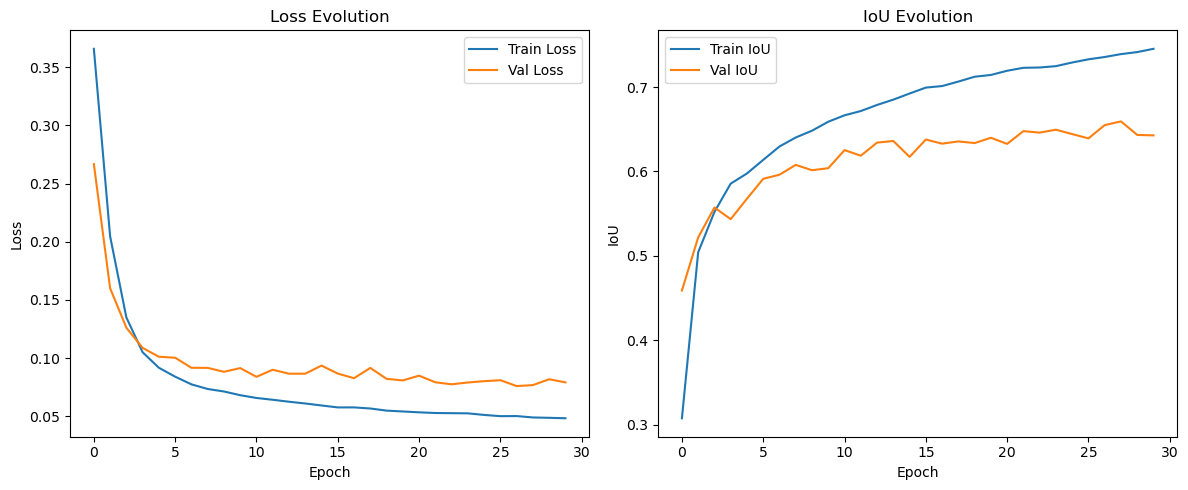

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import random

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check bfloat16 support and setup AMP
if torch.cuda.is_available():
    # Check if GPU supports bfloat16 (Ampere architecture and later: A100, RTX 30xx, RTX 40xx, etc.)
    if torch.cuda.is_bf16_supported():
        use_bf16 = True
        amp_dtype = torch.bfloat16
        print(f"✓ GPU supports bfloat16 - Using AMP with bfloat16")
    else:
        use_bf16 = False
        amp_dtype = torch.float16
        print(f"⚠ GPU does not support bfloat16 - Falling back to float16")
else:
    use_bf16 = False
    amp_dtype = None
    print(f"⚠ CUDA not available - AMP disabled")

# Create GradScaler for AMP
# Note: bfloat16 typically doesn't need scaling, but using scaler is still recommended for safety
scaler = GradScaler('cuda') if device.type == 'cuda' else None

# Create output directories
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(config.VIZ_DIR, exist_ok=True)
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

print(f"\nOutput directories created:")
print(f"  Main output: {config.OUTPUT_DIR}/")
print(f"  Visualizations: {config.VIZ_DIR}/")
print(f"  Checkpoints: {config.CHECKPOINT_DIR}/")

# Set paths for visualization and checkpoints
viz_dir = config.VIZ_DIR
checkpoint_dir = config.CHECKPOINT_DIR

def denormalize_imagenet(img_tensor):
    """
    Denormalize ImageNet-normalized images for correct display.
    
    Args:
        img_tensor: Tensor of shape (B, C, H, W) or (B, H, W, C) or (C, H, W) or numpy array of shape (H, W, C)
                    with ImageNet normalization applied
    
    Returns:
        Denormalized image in range [0, 1] ready for display
    """
    # ImageNet mean and std
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Handle different input formats
    if isinstance(img_tensor, torch.Tensor):
        img_np = img_tensor.cpu().numpy()
    else:
        img_np = img_tensor.copy()
    
    # Handle different tensor shapes
    if len(img_np.shape) == 4:  # Batch dimension present
        # Check if it's (B, C, H, W) or (B, H, W, C)
        if img_np.shape[1] == 3:  # (B, C, H, W)
            # Permute to (B, H, W, C) for easier broadcasting
            img_np = img_np.transpose(0, 2, 3, 1)
        # img_np is now (B, H, W, C)
        # Denormalize: img = img * std + mean
        img_np = img_np * std + mean
    elif len(img_np.shape) == 3:
        if img_np.shape[0] == 3:  # (C, H, W)
            # Permute to (H, W, C)
            img_np = img_np.transpose(1, 2, 0)
        # img_np is now (H, W, C)
        img_np = img_np * std + mean
    
    # Clip to valid range [0, 1]
    img_np = np.clip(img_np, 0, 1)
    
    return img_np


def save_visualization(images, masks, predictions, epoch, split='train', num_images=2):
    """
    Save visualization images showing original, GT mask, predicted mask, and overlay.
    
    Args:
        images: Tensor of shape (B, C, H, W) - original images (ImageNet normalized)
        masks: Tensor of shape (B, 1, H, W) - ground truth masks
        predictions: Tensor of shape (B, 1, H, W) - predicted masks
        epoch: Current epoch number
        split: 'train' or 'val'
        num_images: Number of images to save
    """
    # Convert tensors to numpy and move to CPU
    # Convert to float32 first to handle bfloat16/float16 from AMP
    images_np = images.cpu().permute(0, 2, 3, 1).float().numpy()  # (B, H, W, C)
    masks_np = masks.cpu().squeeze(1).float().numpy()  # (B, H, W)
    preds_np = predictions.cpu().squeeze(1).float().numpy()  # (B, H, W)
    
    # Denormalize images for correct display (reverse ImageNet normalization)
    images_np = denormalize_imagenet(images_np)
    
    # Threshold predictions
    preds_binary = (preds_np > 0.5).astype(np.float32)
    
    # All images are forged, so just select random images
    batch_size = masks_np.shape[0]
    num_images_to_show = min(num_images, batch_size)
    selected_indices = np.random.choice(batch_size, size=num_images_to_show, replace=False)
    
    # Save selected images
    for img_idx, i in enumerate(selected_indices):
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Original image (already denormalized)
        img = images_np[i]
        axes[0].imshow(img)
        axes[0].set_title('Original Image (Forged)')
        axes[0].axis('off')
        
        # Ground truth mask
        axes[1].imshow(masks_np[i], cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')
        
        # Predicted mask
        axes[2].imshow(preds_binary[i], cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')
        
        # Overlay: original image with predicted mask in red
        overlay = img.copy()
        # Create colored mask (red channel)
        mask_colored = np.zeros_like(overlay)
        mask_colored[:, :, 0] = preds_binary[i]  # Red channel
        # Blend original with colored mask
        overlay = np.clip(overlay * 0.6 + mask_colored * 0.4, 0, 1)
        axes[3].imshow(overlay)
        axes[3].set_title('Overlay (Original + Prediction)')
        axes[3].axis('off')
        
        plt.tight_layout()
        save_path = os.path.join(viz_dir, f'epoch_{epoch:03d}_{split}_{img_idx+1}.png')
        # Increased DPI from 100 to 150 for sharper visualization images (especially for 512x512)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()



# Loss functions
class DiceLoss(nn.Module):
    """Dice Loss for binary segmentation"""
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        # Flatten tensors
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Calculate Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Return Dice loss (1 - Dice coefficient)
        return 1 - dice

class FocalLoss(nn.Module):
    """Focal Loss for binary segmentation - addresses class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, logits, targets):
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        
        # Calculate BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        
        # Calculate p_t (probability of true class)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        
        # Calculate alpha_t (alpha for true class)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        # Calculate focal weight
        focal_weight = alpha_t * (1 - p_t) ** self.gamma
        
        # Apply focal weight to BCE loss
        focal_loss = focal_weight * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class CombinedLoss(nn.Module):
    """Combined Focal and Dice Loss for segmentation"""
    def __init__(self, focal_weight=0.5, dice_weight=0.5, dice_smooth=1e-6, focal_alpha=0.25, focal_gamma=2.0):
        super(CombinedLoss, self).__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        # FocalLoss expects logits, applies sigmoid internally
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        self.dice_loss = DiceLoss(smooth=dice_smooth)
    
    def forward(self, mask_logits, mask_targets):
        # Segmentation loss (Focal + Dice)
        # FocalLoss expects logits, applies sigmoid internally
        seg_focal = self.focal_loss(mask_logits, mask_targets)
        # DiceLoss expects probabilities, so apply sigmoid to logits
        mask_probs = torch.sigmoid(mask_logits)
        seg_dice = self.dice_loss(mask_probs, mask_targets)
        seg_loss = self.focal_weight * seg_focal + self.dice_weight * seg_dice
        
        return seg_loss

# Create combined loss function
criterion = CombinedLoss(
    focal_weight=config.FOCAL_WEIGHT,
    dice_weight=config.DICE_WEIGHT,
    dice_smooth=config.DICE_SMOOTH,
    focal_alpha=config.FOCAL_ALPHA,
    focal_gamma=config.FOCAL_GAMMA
)

if config.OPTIMIZER.lower() == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
elif config.OPTIMIZER.lower() == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY, momentum=0.9)
else:
    raise ValueError(f"Unknown optimizer: {config.OPTIMIZER}. Use 'adam' or 'sgd'.")

# ============================================================================
# TRAINING LOOP
# ============================================================================

print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)
print(f"Total epochs: {config.NUM_EPOCHS}")
print(f"Curriculum Learning: {'ENABLED' if config.USE_CURRICULUM_LEARNING else 'DISABLED'}")
print("=" * 60)

# Training loop
num_epochs = config.NUM_EPOCHS

for epoch in range(num_epochs):
    # Use curriculum learning if enabled
    if config.USE_CURRICULUM_LEARNING and 'create_curriculum_dataloader' in globals():
        new_train_loader, train_sampler_info, new_val_loader, val_sampler_info = create_curriculum_dataloader(epoch)
        # Only update loaders if valid loaders were returned
        if new_train_loader is not None:
            train_loader = new_train_loader
        if new_val_loader is not None:
            val_loader = new_val_loader
        if train_sampler_info is not None and val_sampler_info is not None:
            groups_str = train_sampler_info['groups_used'] if isinstance(train_sampler_info['groups_used'], str) else "all"
            print(f"\nEpoch {epoch+1}: Using curriculum groups {groups_str}")
            print(f"  Train: {train_sampler_info['size']} samples (mean area: {train_sampler_info['mean_area']:.1f})")
            print(f"  Val: {val_sampler_info['size']} samples (mean area: {val_sampler_info['mean_area']:.1f})")
    
    # Calculate number of batches for random selection
    # Ensure train_loader and val_loader exist and are valid
    if train_loader is None:
        raise ValueError("train_loader is None! Make sure dataset split cell (Cell 4) was run.")
    if val_loader is None:
        raise ValueError("val_loader is None! Make sure dataset split cell (Cell 4) was run.")
    num_train_batches = len(train_loader)
    num_val_batches = len(val_loader)
    
    # Randomly select a batch index for visualization this epoch
    # Ensure we have at least one batch, and use safe random selection
    if num_train_batches > 0:
        random_train_batch_idx = random.randint(0, num_train_batches - 1)
    else:
        random_train_batch_idx = 0
    
    if num_val_batches > 0:
        random_val_batch_idx = random.randint(0, num_val_batches - 1)
    else:
        random_val_batch_idx = 0
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_iou_sum = 0.0
    train_batches = 0
    train_images_batch = None
    train_masks_batch = None
    train_outputs_batch = None
    
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.NUM_EPOCHS} [Train]')
    
    for batch_idx, (images, masks, class_labels) in enumerate(train_pbar):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass with AMP (Automatic Mixed Precision)
        optimizer.zero_grad()
        
        # Use autocast context for forward pass (uses bfloat16 or float16)
        with autocast(device_type='cuda', dtype=amp_dtype):
            mask_outputs = model(images)
            
            # Calculate loss (segmentation only)
            loss = criterion(mask_outputs, masks)
        
        # Backward pass
        # Use scaler for gradient scaling (important for fp16, optional for bf16)
        if scaler is not None:
            scaler.scale(loss).backward()
            # Unscale gradients before clipping (required when using scaler)
            scaler.unscale_(optimizer)
            # Clip gradient norm to 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            # Clip gradient norm to 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Save batch for visualization - always save first batch, or randomly selected batch
        # This ensures we always have visualizations even if random selection fails
        if batch_idx == 0 or batch_idx == random_train_batch_idx:
            train_images_batch = images.detach().clone()
            train_masks_batch = masks.detach().clone()
            train_outputs_batch = torch.sigmoid(mask_outputs.detach().clone())  # Convert logits to probs
        
        # Calculate metrics
        train_loss += loss.item()
        
        # IoU for segmentation (apply sigmoid to logits first)
        mask_probs = torch.sigmoid(mask_outputs)
        predicted = (mask_probs > 0.5).float()
        intersection = (predicted * masks).sum(dim=(1, 2, 3))
        union = predicted.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection
        iou = (intersection / (union + 1e-6)).mean()
        train_iou_sum += iou.item()
        
        train_batches += 1
        
        train_pbar.set_postfix({
            'loss': loss.item(),
            'iou': iou.item()
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_iou = train_iou_sum / train_batches if train_batches > 0 else 0.0
    
    history['train_loss'].append(avg_train_loss)
    history['train_iou'].append(train_iou)
    
    # Save training visualizations (should always be available since we save batch 0)
    if train_images_batch is not None:
        try:
            save_visualization(train_images_batch, train_masks_batch, train_outputs_batch, 
                             epoch + 1, split='train', num_images=config.NUM_VIZ_IMAGES)
        except Exception as e:
            print(f"  Warning: Failed to save training visualizations: {e}")
    else:
        print(f"  Warning: No training batch captured for visualization in epoch {epoch + 1}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_iou_sum = 0.0
    val_batches = 0
    val_images_batch = None
    val_masks_batch = None
    val_outputs_batch = None
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{config.NUM_EPOCHS} [Val]')
        for batch_idx, (images, masks, class_labels) in enumerate(val_pbar):
            images = images.to(device)
            masks = masks.to(device)
            
            # Use autocast for validation forward pass as well
            with autocast(device_type='cuda', dtype=amp_dtype):
                mask_outputs = model(images)
                loss = criterion(mask_outputs, masks)
            
            # Save batch for visualization - always save first batch, or randomly selected batch
            # This ensures we always have visualizations even if random selection fails
            if batch_idx == 0 or batch_idx == random_val_batch_idx:
                val_images_batch = images.clone()  # Already in no_grad context
                val_masks_batch = masks.clone()
                val_outputs_batch = torch.sigmoid(mask_outputs.clone())  # Convert logits to probs
            
            val_loss += loss.item()
            
            # IoU for segmentation (apply sigmoid to logits first)
            mask_probs = torch.sigmoid(mask_outputs)
            predicted = (mask_probs > 0.5).float()
            intersection = (predicted * masks).sum(dim=(1, 2, 3))
            union = predicted.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection
            iou = (intersection / (union + 1e-6)).mean()
            val_iou_sum += iou.item()
            
            val_batches += 1
            
            val_pbar.set_postfix({
                'loss': loss.item(),
                'iou': iou.item()
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_iou = val_iou_sum / val_batches if val_batches > 0 else 0.0
    
    history['val_loss'].append(avg_val_loss)
    history['val_iou'].append(val_iou)
    
    # Save validation visualizations (should always be available since we save batch 0)
    if val_images_batch is not None:
        try:
            save_visualization(val_images_batch, val_masks_batch, val_outputs_batch, 
                             epoch + 1, split='val', num_images=config.NUM_VIZ_IMAGES)
        except Exception as e:
            print(f"  Warning: Failed to save validation visualizations: {e}")
    else:
        print(f"  Warning: No validation batch captured for visualization in epoch {epoch + 1}")
    
    print(f'Epoch {epoch+1}/{config.NUM_EPOCHS}:')
    print(f'  Train Loss: {avg_train_loss:.4f}, Train IoU: {train_iou:.4f}')
    print(f'  Val Loss: {avg_val_loss:.4f}, Val IoU: {val_iou:.4f}')
    print(f'  Visualizations saved to {viz_dir}/')
    
    # Model checkpointing
    if avg_val_loss < best_val_loss - config.MIN_DELTA:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        checkpoint_path = os.path.join(checkpoint_dir, config.MODEL_SAVE_NAME)
        torch.save(best_model_state, checkpoint_path)
        print(f'  ✓ Model saved to {checkpoint_path}! (Val Loss: {avg_val_loss:.4f})')
    else:
        patience_counter += 1
        print(f'  No improvement. Patience: {patience_counter}/{patience}')
    
    # Early stopping
    if patience_counter >= patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f'\nBest model loaded with validation loss: {best_val_loss:.4f}')

# Plot training history
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# IoU
plt.subplot(1, 2, 2)
plt.plot(history['train_iou'], label='Train IoU')
plt.plot(history['val_iou'], label='Val IoU')
plt.legend()
plt.title('IoU Evolution')
plt.xlabel('Epoch')
plt.ylabel('IoU')

plt.tight_layout()
plt.show()

Randomly selected 20 images from validation dataset (indices: [  28  236  615  630  875  310   70 1025  738  440  128  104  569  526
  669  849  962 1021  889  827])


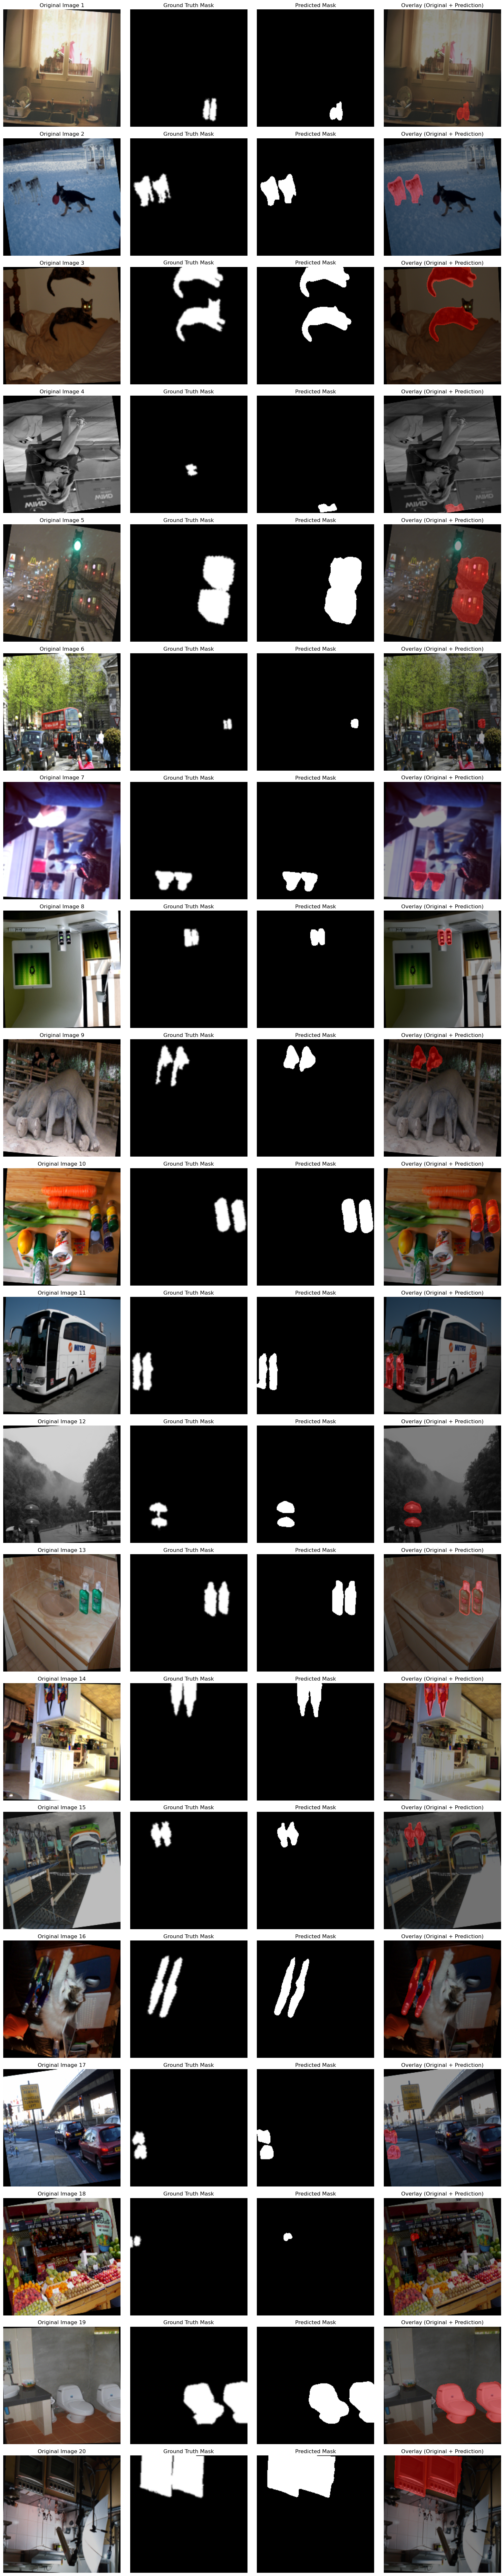


Summary:
  Total test images: 20
  Total predicted mask pixels: 52465
  Average mask pixels per image: 2623.2


In [8]:
# Import AMP if not already imported (for standalone execution)
try:
    from torch.amp import autocast
    # Check if amp_dtype is defined (from training cell)
    if 'amp_dtype' not in globals():
        # Setup AMP for inference
        if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
            amp_dtype = torch.bfloat16
            print("✓ Using AMP with bfloat16 for inference")
        elif torch.cuda.is_available():
            amp_dtype = torch.float16
            print("⚠ Using AMP with float16 for inference")
        else:
            amp_dtype = None
except ImportError:
    amp_dtype = None

# Load the best saved model
checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.MODEL_SAVE_NAME)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Test prediction on 20 randomly selected images from validation dataset
num_test_images = 20
val_size = len(val_dataset_split)
num_test_images = min(num_test_images, val_size)  # Don't exceed dataset size

# Randomly select indices from validation dataset
random_indices = np.random.choice(val_size, size=num_test_images, replace=False)
print(f"Randomly selected {num_test_images} images from validation dataset (indices: {random_indices})")

# Collect images, masks, and predictions
test_images = []
test_masks = []
test_predictions = []

with torch.no_grad():
    for idx in random_indices:
        # Get image and mask from dataset
        img_tensor, mask_tensor, _ = val_dataset_split[idx]
        
        # Move to device and add batch dimension
        img_batch = img_tensor.unsqueeze(0).to(device)
        
        # Make prediction with AMP (if enabled)
        with autocast(device_type='cuda', dtype=amp_dtype):
            prediction_mask_logits = model(img_batch)
        
        # Convert logits to probabilities and threshold
        # Convert to float32 before numpy conversion (bfloat16/float16 not supported by numpy)
        prediction_mask_probs = torch.sigmoid(prediction_mask_logits).float()
        prediction_mask = (prediction_mask_probs.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
        
        # Convert tensors to numpy for visualization
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
        mask_np = mask_tensor.squeeze().cpu().numpy()  # (1, H, W) -> (H, W)
        
        # Denormalize image for correct display (reverse ImageNet normalization)
        img_np = denormalize_imagenet(img_np)
        
        test_images.append(img_np)
        test_masks.append(mask_np)
        test_predictions.append(prediction_mask)

# Visualize results in a grid (5 rows x 4 columns for 20 images)
# Each row shows: Original, GT Mask, Predicted Mask, Overlay
fig, axes = plt.subplots(num_test_images, 4, figsize=(16, 4 * num_test_images))

for i in range(num_test_images):
    # Original image (already denormalized)
    axes[i, 0].imshow(test_images[i])
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')
    
    # Ground truth mask
    axes[i, 1].imshow(test_masks[i], cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 1].axis('off')
    
    # Predicted mask
    axes[i, 2].imshow(test_predictions[i], cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')
    
    # Overlay: original image with predicted mask in red
    overlay = test_images[i].copy()  # Already denormalized
    mask_colored = np.zeros_like(overlay)
    mask_colored[:, :, 0] = test_predictions[i]  # Red channel
    overlay = np.clip(overlay * 0.6 + mask_colored * 0.4, 0, 1)
    axes[i, 3].imshow(overlay)
    axes[i, 3].set_title('Overlay (Original + Prediction)')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics
total_mask_pixels = sum(pred.sum() for pred in test_predictions)
print(f"\nSummary:")
print(f"  Total test images: {num_test_images}")
print(f"  Total predicted mask pixels: {total_mask_pixels}")
print(f"  Average mask pixels per image: {total_mask_pixels / num_test_images:.1f}")

In [9]:
# Save the complete model (architecture + weights + optimizer state)
# Method 1: Save only state dict (recommended - smaller file, requires model definition to load)
complete_state_path = os.path.join(config.CHECKPOINT_DIR, config.MODEL_COMPLETE_NAME)
torch.save(model.state_dict(), complete_state_path)

# Method 2: Save entire model (larger file, but can load without model definition)
complete_checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.MODEL_COMPLETE_NAME.replace('.pth', '.pt'))
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': len(history['train_loss']),
    'val_loss': best_val_loss,
    'model_config': {
        'in_channels': config.IN_CHANNELS, 
        'out_channels': config.OUT_CHANNELS,
        'r': config.CBAM_REDUCTION
    }
}, complete_checkpoint_path)

print("Model saved in PyTorch formats:")
print(f"1. State dict only: {complete_state_path}")
print(f"2. Complete checkpoint: {complete_checkpoint_path}")
print("\nTo load the model later:")
print("  # For state dict:")
print(f"  model = MaxViT_CBAM_UNet(in_channels={config.IN_CHANNELS}, out_channels={config.OUT_CHANNELS}, r={config.CBAM_REDUCTION}).to(device)")
print(f"  model.load_state_dict(torch.load('{complete_state_path}'))")
print("\n  # For complete checkpoint:")
print(f"  checkpoint = torch.load('{complete_checkpoint_path}')")
print("  model.load_state_dict(checkpoint['model_state_dict'])")

Model saved in PyTorch formats:
1. State dict only: outputs/checkpoints/unet_comofod_complete.pth
2. Complete checkpoint: outputs/checkpoints/unet_comofod_complete.pt

To load the model later:
  # For state dict:
  model = MaxViT_CBAM_UNet(in_channels=3, out_channels=1, r=4).to(device)
  model.load_state_dict(torch.load('outputs/checkpoints/unet_comofod_complete.pth'))

  # For complete checkpoint:
  checkpoint = torch.load('outputs/checkpoints/unet_comofod_complete.pt')
  model.load_state_dict(checkpoint['model_state_dict'])
